In [1]:
from modules.cn_allocation import Makela08_alloc_parameter
import numpy as np
import sympy as sp


params_dict = Makela08_alloc_parameter.get_param_dict(dict_name="params_makela08_pine")

def matrix_generator(x_start, x_end, y_start, y_end, step):
    """
    Generate 2-D matrix containing Light and N availability gradients
    
    X: (sigma_rM) N availability (kg N / kg FR / yr)
    `Nup_max_specific`
    
    Y: (sigma_fM) Light saturated foliar-specific photosynthetic rate (kg C / kg foliage / yr)
    `Photosyn_lightsat`
    
    :return: target matrix
    """
    num_x = int((x_end - x_start) / step) + 1
    num_y = int((y_end - y_start) / step) + 1
    matrix_n = np.zeros((num_y, num_x))
    matrix_p = np.zeros((num_y, num_x))
    
    for _i in range(num_y):
        for _j in range(num_x):
            matrix_n[_i][_j] = x_start + _j * step
            matrix_p[_i][_j] = y_start + _i * step
    return matrix_n, matrix_p

gradient_matrix_n, gradient_matrix_p = matrix_generator(0, 10, 0, 10, 1)

In [2]:
# Load parameters into separate values
AvgLongevity_foliage = params_dict["AvgLongevity_foliage"]
AvgLongevity_wood = params_dict["AvgLongevity_wood"]
AvgLongevity_root = params_dict["AvgLongevity_root"]

NResorbFrac_foliage = params_dict["NResorbFrac_foliage"]
NResorbFrac_wood = params_dict["NResorbFrac_wood"]
NResorbFrac_root = params_dict["NResorbFrac_root"]

alpha_w = params_dict["alpha_w"]
c_H = params_dict["c_H"]
NrNf_ratio = params_dict["NrNf_ratio"]
NwNf_ratio = params_dict["NwNf_ratio"]
Resp_Nspecific = params_dict["Resp_Nspecific"]
CtoDM_frac = params_dict["CtoDM_frac"]
Kr = params_dict["Kr"]
Kf = params_dict["Kf"]

In [3]:
# Define symbolic variables
Nconc_foliage, psi_r, Photosyn_lightsat, Nup_max_specific = sp.symbols('Nconc_foliage psi_r Photosyn_lightsat Nup_max_specific')

exp_beta1 = CtoDM_frac * Photosyn_lightsat * Kf / (1 / AvgLongevity_root + Resp_Nspecific * Nconc_foliage * NrNf_ratio)

exp_beta2 = (1 / AvgLongevity_foliage + Nconc_foliage * (
            alpha_w * c_H / AvgLongevity_wood +
            CtoDM_frac * Resp_Nspecific * (1 + NwNf_ratio * alpha_w * c_H * Nconc_foliage)
    )) / (1 / AvgLongevity_root + CtoDM_frac * Resp_Nspecific * Nconc_foliage * NrNf_ratio)

exp_beta3 = (Nup_max_specific * Kr) / (
            Nconc_foliage * (1 - NResorbFrac_root) * NrNf_ratio / AvgLongevity_root
    )

exp_beta4 = (
                    (1 - NResorbFrac_foliage) / AvgLongevity_foliage +
                    (1 - NResorbFrac_wood) * NwNf_ratio * alpha_w * c_H * Nconc_foliage / AvgLongevity_wood
            ) / (
                    (1 - NResorbFrac_root) * NrNf_ratio / AvgLongevity_root
            )

exp_a1 = sp.simplify( (exp_beta1 - exp_beta3 + Kr - Kf * (exp_beta2 + exp_beta4)) / -Kf )
exp_a2 = sp.simplify( (exp_beta1 * exp_beta4 - exp_beta2 * exp_beta3 + Kr * (exp_beta2 + exp_beta4) - Kf * exp_beta2 * exp_beta4) / -Kf )
exp_a3 = sp.simplify( Kr * exp_beta2 * exp_beta4 / -Kf )

exp_cubiceq_psi_r = sp.simplify( psi_r**3 + exp_a1*psi_r**2 + exp_a2*psi_r + exp_a3 )

# Symbolic solutions, containing Nconc_foliage, psi_r, Photosyn_lightsat, Nup_max_specific
# Photosyn_lightsat, Nup_max_specific is evaluated later so the final solution is psi_r given a Nconc_foliage.
exp_cubiceq_psi_r_solutions = sp.solve(exp_cubiceq_psi_r, psi_r)

# simplified_expression = sp.simplify(expression)

In [4]:
# Enumerate the 2-D matrix
psi_r_solution_dict = {}
try:
    for i in range(len(gradient_matrix_n)):  # or gradient_matrix_p
        for j in range(len(gradient_matrix_n[i])):
            _Nup_max_specific = gradient_matrix_n[i, j]
            _Photosyn_lightsat = gradient_matrix_p[i, j]
            
            # Symbolic solutions of psi_r containing only Nconc_foliage as variable
            psi_r_solution_list = [i.evalf(subs={Nup_max_specific:_Nup_max_specific,Photosyn_lightsat:_Photosyn_lightsat}) for i in exp_cubiceq_psi_r_solutions]
            
            psi_r_solution_dict[(_Nup_max_specific, _Photosyn_lightsat)] = psi_r_solution_list
            # raise StopIteration
except StopIteration:
    pass

# Pick one for further optimization
test_Nup_max_specific = 4
test_Photosyn_lightsat = 8
psi_r_solution_example = psi_r_solution_dict[(test_Nup_max_specific, test_Photosyn_lightsat)]

# Check if there is any real roots (do not contain complex units)


In [5]:
evaluated_pai_r_value = [exp_cubiceq_psi_r_solution.subs({Nconc_foliage:4}) for exp_cubiceq_psi_r_solution in psi_r_solution_example]

psi_r_solution_non_complex = [expr for expr in evaluated_pai_r_value if not expr.has(sp.I)]

In [10]:
from modules.cn_allocation import Makela08_alloc_symbsolver

Wf_solver = Makela08_alloc_symbsolver.DryMassFoliageSolver(
    test_Nup_max_specific, test_Photosyn_lightsat, params_dict
)

symb_DM_foliage_C = Wf_solver.solve_carbon(psi_r_solution_example[0])[0]
symb_DM_foliage_N = Wf_solver.solve_nitrogen(psi_r_solution_example[0])[0]

G_solver = Makela08_alloc_symbsolver.BiomassProductionSolver(params_dict)

symb_G_C = G_solver.solve_total_biomass_production(symb_DM_foliage_C, psi_r_solution_example[0])
symb_G_N = G_solver.solve_total_biomass_production(symb_DM_foliage_N, psi_r_solution_example[0])


In [11]:
import matplotlib.pyplot as plt
G_optimizer = Makela08_alloc_symbsolver.BiomassProductionOptimizer(symb_G_C, symb_G_N)
# Nconc_foliage_maxG, maxG_value = G_optimizer.optimize_total_biomass_production(100, 1000, "C")
# print(Nconc_foliage_maxG)
# print("-------")
# print(maxG_value)
# symb_G_C = G_optimizer.optimize_total_biomass_production(100, 1000, "C")


(-2500 + 30800.0/((16*Nconc_foliage + 0.8)*(-0.0020614306328592*(-3.0*(7215704939520.0*Nconc_foliage**5 - 145697443584.0*Nconc_foliage**4 + 8337636250944.0*Nconc_foliage**3 + 591522941380.0*Nconc_foliage**2 + 9345708500.0*Nconc_foliage + 33000000.0)/(9391536000.0*Nconc_foliage**3 + 774496800.0*Nconc_foliage**2 + 15246000.0*Nconc_foliage) + 26146.89*(Nconc_foliage**4 + 0.0686184666704147*Nconc_foliage**3 + 0.0314993111122307*Nconc_foliage**2 + 0.00275927131817067*Nconc_foliage + 5.7368199430219e-5)**2/(Nconc_foliage**3 + 0.0824675324675325*Nconc_foliage**2 + 0.00162337662337662*Nconc_foliage)**2)/((-0.999999999999999*(-0.000114736398860438*(7215704939520.0*Nconc_foliage**5 - 145697443584.0*Nconc_foliage**4 + 8337636250944.0*Nconc_foliage**3 + 591522941380.0*Nconc_foliage**2 + 9345708500.0*Nconc_foliage + 33000000.0)/(9391536000.0*Nconc_foliage**3 + 774496800.0*Nconc_foliage**2 + 15246000.0*Nconc_foliage) + (Nconc_foliage**4 + 0.0686184666704147*Nconc_foliage**3 + 0.0314993111122307*Ncon

<string>:1: RuntimeWarning: invalid value encountered in scalar power


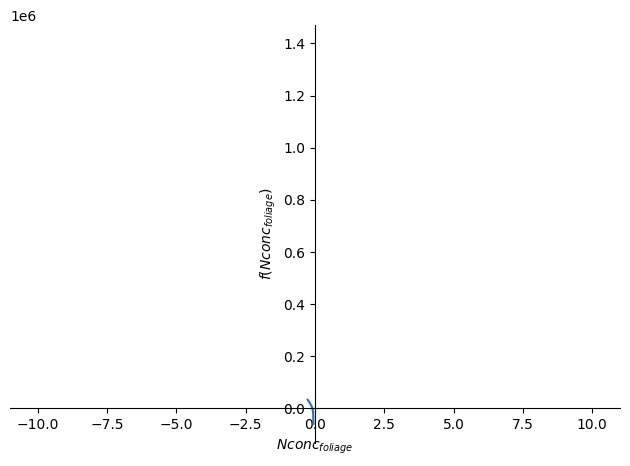

In [13]:
print(symb_G_C)
# x_vals = np.linspace(100,1000,4500)
# y_vals = symb_G_C(x_vals)
# print(y_vals)
# plt.plot(x_vals,y_vals)
Nconc_foliage = sp.Symbol("Nconc_foliage")
sp.plotting.plot(symb_G_C)


In [18]:
print(f_numeric(1010000000))

nan
